# 1. Community Detection Algorithms

This notebook showcases all the community detection algorithms applied to the SBB train network.
It runs each technique, shows some statistics about the results, and plots the graph with communities.
The plots only consider the network's structure, not the coordinates of the stations.
The notebook `network_exploration.ipynb` contains a plot of the network that uses coordinates of the stations.

All community detection techniques are performed on the largest connected component.
Louvain is applied to the entire graph for demonstration purposes.
The performance evaluation of each algorithm is available in `community_detection_evaluation.ipynb`.

The graph is loaded from the `data/sbb.edgelist`.
We provide the edge list with the project.  
To reproduce the pre-processing steps with Neo4j, you can create the edge list yourself with the `create_edgelist.py` script.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
G = nx.read_edgelist("data/sbb.edgelist", delimiter=";", create_using=nx.Graph)

print(f"number of nodes: {len(G.nodes)}")
print(f"number of edges: {len(G.edges)}")

# we apply the techniques on the largest connected components
connected_comp = nx.connected_components(G)
max_connected_comp = max(connected_comp)
print("Number of nodes in largest connected component:", len(max_connected_comp))

G_lcc = G.subgraph(max_connected_comp)

number of nodes: 3152
number of edges: 4678
Number of nodes in largest connected component: 3017


In [3]:
import random

random.seed(42)
getcolors = lambda n: ["#%06x" % random.randint(0, 0xFFFFFF) for _ in range(n)]
colors = getcolors(100)

def community_stats(communities, algorithm_name):
    comms_len = [len(c) for c in communities]
    print(f"{algorithm_name}: number of communities: {len(communities)}")
    print(f"{algorithm_name}: size of each community: {comms_len}")


def plot_communities(G, communities, algorithm_name):
    plt.figure(figsize=(12, 9))    
    pos = nx.spring_layout(G, seed=42)     
    for i, c in enumerate(communities):
        nx.draw_networkx_nodes(     
            G, pos=pos, nodelist=c, node_color=colors[i], node_size=10, alpha=0.75        
        )            

    nx.draw_networkx_edges(G, pos=pos, width=0.20, alpha=0.33)
    plt.title(f"{algorithm_name} Communities")
    plt.show()

## 1.1 Louvain

### 1.1.1 Louvain on the Full Graph

In [4]:
louvain = nx.community.louvain_communities(G, seed=42)

community_stats(louvain, "Louvain (Full Graph)")

Louvain (Full Graph): number of communities: 57
Louvain (Full Graph): size of each community: [98, 93, 131, 47, 25, 20, 26, 222, 15, 13, 117, 13, 30, 32, 12, 19, 137, 55, 83, 45, 18, 24, 99, 156, 51, 18, 20, 43, 12, 50, 3, 98, 27, 24, 74, 103, 38, 128, 20, 29, 17, 9, 202, 2, 212, 50, 50, 94, 20, 20, 79, 29, 64, 12, 7, 10, 7]


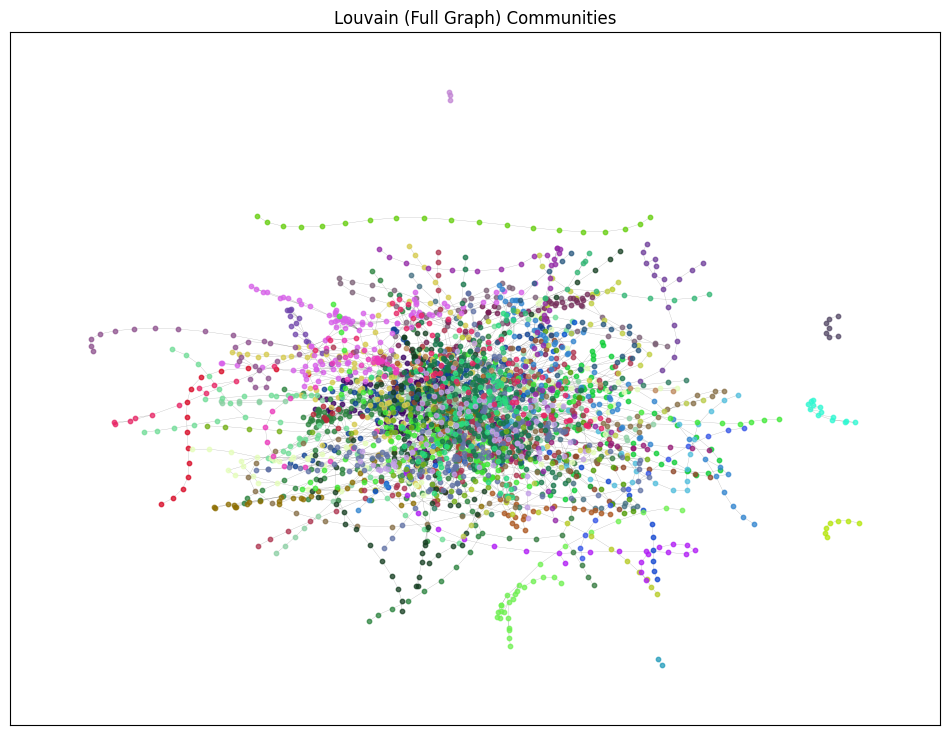

In [5]:
plot_communities(G, louvain, "Louvain (Full Graph)")

### 1.1.2 Louvain: Largest Connected Components

In [6]:
louvain = nx.community.louvain_communities(G_lcc, seed=42)

community_stats(louvain, "Louvain")       

Louvain: number of communities: 45
Louvain: size of each community: [93, 27, 18, 116, 116, 15, 13, 151, 79, 61, 121, 85, 134, 104, 45, 156, 135, 15, 23, 32, 51, 18, 20, 135, 43, 27, 25, 24, 19, 38, 113, 50, 72, 17, 202, 28, 43, 20, 56, 50, 29, 117, 20, 50, 211]


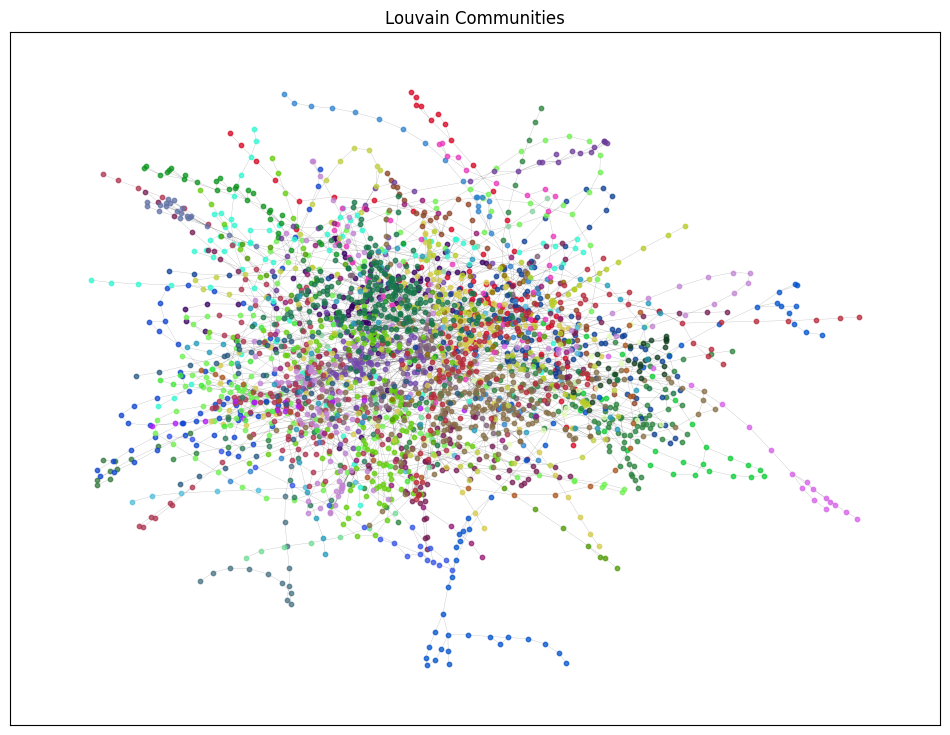

In [7]:
plot_communities(G_lcc, louvain, "Louvain")

### 1.1.3 Louvain: our Implementation

In [8]:
from louvain import louvain_implementation

G_lcc = nx.Graph(G_lcc)
louvain_imp = louvain_implementation(G_lcc)

community_stats(louvain_imp, "Louvain Implementation")

Louvain Implementation: number of communities: 34
Louvain Implementation: size of each community: [87, 147, 93, 150, 87, 146, 116, 86, 55, 145, 64, 44, 51, 18, 57, 44, 126, 98, 27, 24, 50, 24, 38, 98, 232, 50, 128, 80, 138, 116, 56, 243, 52, 47]


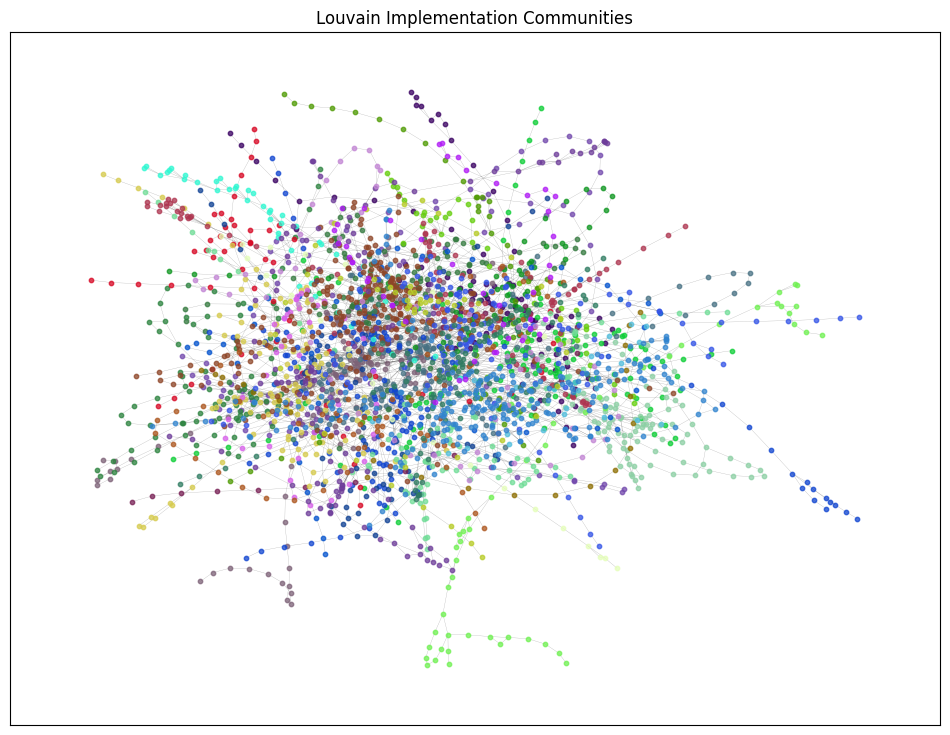

In [9]:
plot_communities(G_lcc, louvain_imp, "Louvain Implementation")

## 1.2 Girvan-Newman

**Important**: Girvan-Newman takes a while to run!

You can adjust how many hours you want Girvan-Newman to iterate for with the `hour_time_threshold`.

In [ ]:
import time

def girvan_newman(G, hour_time_threshold=1):
    gn_communities = nx.community.girvan_newman(G)

    iter_count = 0
    coms = []

    # Apply Girvan-Newman iteratively for > time_threshold hour
    timeout = time.time() + 60 * hour_time_threshold
    while True:
        if time.time() > timeout:
            break
        
        iter_count += 1
        coms = next(gn_communities, 'end')

    print(f'number of iterations: {iter_count}')
    return coms

# hour_time_threshold is the number of hours you want to run the algorithm for
gn = girvan_newman(G_lcc, hour_time_threshold=2)

community_stats(gn, "Girvan Newman")

In [ ]:
plot_communities(G_lcc, gn, "Girvan Newman")

## 1.3 Leiden

In [10]:
import leidenalg as la
import igraph as ig

def leiden_communities(G):
    # leidenalg only works with an igraph
    graph = ig.Graph.from_networkx(G, vertex_attr_hashable='name')

    partition = list(la.find_partition(graph, la.ModularityVertexPartition))
    # igraph store node ids, not names. convert the ids back to names in the communities found
    idx2name = {idx: name for idx, name in enumerate(list(G.nodes))}
    communities = []
    for comm in partition:
        communities.append({idx2name[n] for n in comm})
        
    return communities

In [11]:
leiden = leiden_communities(G_lcc)

community_stats(leiden, "Leiden")

Leiden: number of communities: 46
Leiden: size of each community: [186, 168, 139, 119, 119, 116, 113, 111, 108, 107, 105, 104, 99, 93, 92, 90, 89, 83, 70, 65, 58, 56, 51, 50, 47, 47, 46, 44, 44, 40, 38, 37, 29, 27, 25, 24, 24, 20, 20, 20, 19, 18, 15, 15, 14, 13]


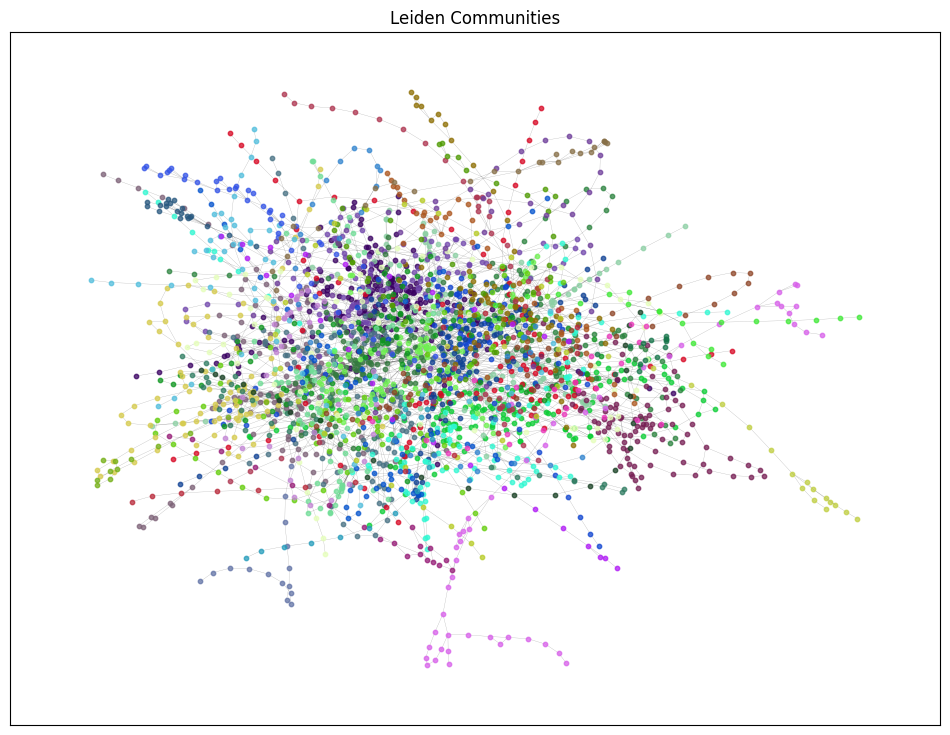

In [12]:
plot_communities(G_lcc, leiden, "Leiden")